### Importing utilities:

In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v11.1/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'fzo1KO', 'LatA', 'CK666')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = [2,224,224]

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [5]:
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])

stats_name = "yeast_v11.1_per_class.dict"
main_stats = Statistics.per_class(train_val, save_name = stats_name)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v11.1\train\02_mfb1KO
working on: datasets\yeast_v11.1\val\02_mfb1KO
working on: datasets\yeast_v11.1\train\02_mmr1KO
working on: datasets\yeast_v11.1\val\02_mmr1KO
working on: datasets\yeast_v11.1\train\02_WT
working on: datasets\yeast_v11.1\val\02_WT
working on: datasets\yeast_v11.1\train\03_CK666
working on: datasets\yeast_v11.1\val\03_CK666
working on: datasets\yeast_v11.1\train\03_dnm1KO
working on: datasets\yeast_v11.1\val\03_dnm1KO
working on: datasets\yeast_v11.1\train\03_fzo1KO
working on: datasets\yeast_v11.1\val\03_fzo1KO
working on: datasets\yeast_v11.1\train\03_LatA-5uM
working on: datasets\yeast_v11.1\val\03_LatA-5uM
working on: datasets\yeast_v11.1\train\03_WT
working on: datasets\yeast_v11.1\val\03_WT
working on: datasets\yeast_v11.1\train\04_WT
working on: datasets\yeast_v11.1\val\04_WT
working on: datasets\yeast_v11.1\test\01_mfb1KO
working on: datasets\yeast_v11.1\test\01_mmm1KO
working on: datasets\yeast_v11.1\test\01_mmr1KO
working on: da

In [6]:
# printing out calculated statistics 
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

02_mfb1KO: 	 	 	 (array([0.00794, 0.00484]), array([0.00075, 0.00163]))
02_mmr1KO: 	 	 	 (array([0.00799, 0.00503]), array([0.0008 , 0.00186]))
02_WT: 	 	 	 (array([0.00796, 0.00478]), array([0.00075, 0.00149]))
03_CK666: 	 	 	 (array([0.02536, 0.00504]), array([0.00261, 0.00168]))
03_dnm1KO: 	 	 	 (array([0.02515, 0.00477]), array([0.0025 , 0.00192]))
03_fzo1KO: 	 	 	 (array([0.02517, 0.0047 ]), array([0.00202, 0.00202]))
03_LatA-5uM: 	 	 	 (array([0.0253, 0.0049]), array([0.0024, 0.0017]))
03_WT: 	 	 	 (array([0.02536, 0.00459]), array([0.00255, 0.00147]))
04_WT: 	 	 	 (array([0.02535, 0.00493]), array([0.00215, 0.00156]))


In [7]:
# printing out calculated statistics 
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.0211 , 0.00454]), array([0.00151, 0.00165]))
01_mmm1KO: 	 	 	 (array([0.02102, 0.00424]), array([0.0015 , 0.00181]))
01_mmr1KO: 	 	 	 (array([0.02115, 0.00486]), array([0.00158, 0.00193]))
01_num1KO: 	 	 	 (array([0.02099, 0.00499]), array([0.00156, 0.00208]))
01_WT: 	 	 	 (array([0.0211 , 0.00449]), array([0.00149, 0.00129]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.00792, 0.00489]), array([0.00072, 0.00163]))
03_axl1KO: 	 	 	 (array([0.02547, 0.00477]), array([0.00224, 0.00144]))
03_bud1KO: 	 	 	 (array([0.02543, 0.00459]), array([0.00222, 0.00142]))
03_DTT: 	 	 	 (array([0.02585, 0.00495]), array([0.00225, 0.00166]))
03_Eth: 	 	 	 (array([0.02533, 0.00469]), array([0.00227, 0.00133]))
03_H2O2: 	 	 	 (array([0.02573, 0.00364]), array([0.00224, 0.00018]))
03_LatA-05uM: 	 	 	 (array([0.02535, 0.00497]), array([0.0025 , 0.00169]))


## Defining datasets:

In [8]:
# defining transformations applied to test-dataset

def tfms_for_test(stats, sz):
    test_norm = Normalize(stats, IntNorm=True)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [9]:

def get_data(path: str, sz, bs): 
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers = 8,
                                                                             test_name='test', test_with_labels=True,
                                                                              balance=True)
    
    # repacking calculated stats
    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}

    # defining transformations for trn
    augs = [RandomDihedral(),
            RandomRotate(90),
            Gauss_noise(stats = main_stats_X, IntNorm=True)
           ]
    
    # composing transformations
    tfms = tfms_from_stats_IntNorm(main_stats_X, sz, aug_tfms=augs, crop_type=CropType.CENTER, pad=sz[1]//8)
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
    return create(tfms), lbl2index, lbl2index_test

In [10]:
data, lbl2idx, lbl2idx_test = get_data(PATH,SIZE,BATCH_SIZE)

In [ ]:
x , y = next(iter(data.trn_dl)) # run 1st iteration of dataloader 

In [ ]:
print(data.aug_dl.dataset.transform.tfms)

### Inspect loaded data:

Displaying the same image with and without normalization.

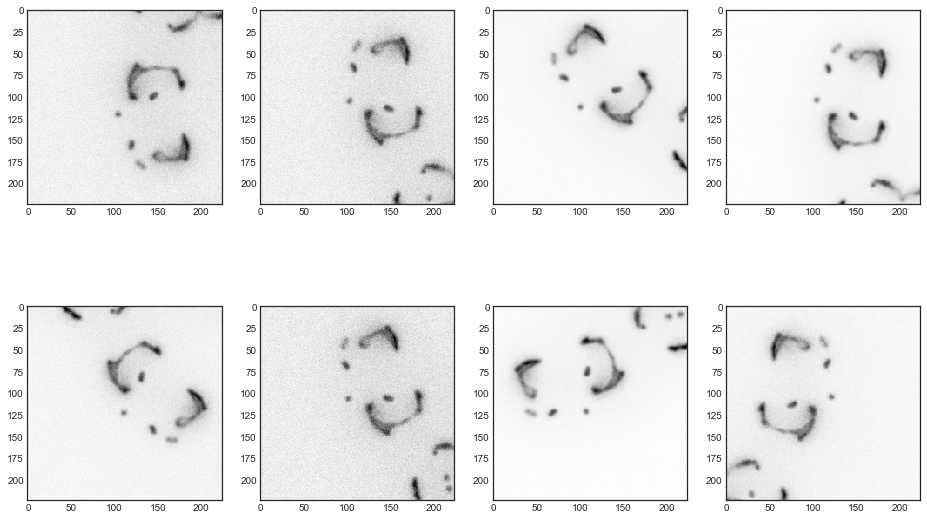

In [11]:
# print transformations
plt.style.use('seaborn-white')

c = 1
idx = 0
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [12]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

    for b in range(0,len(dl)):
        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [13]:
xs, ys =  load_epoch()

In [14]:
import seaborn as sns

(5017600,)
(5017600,)


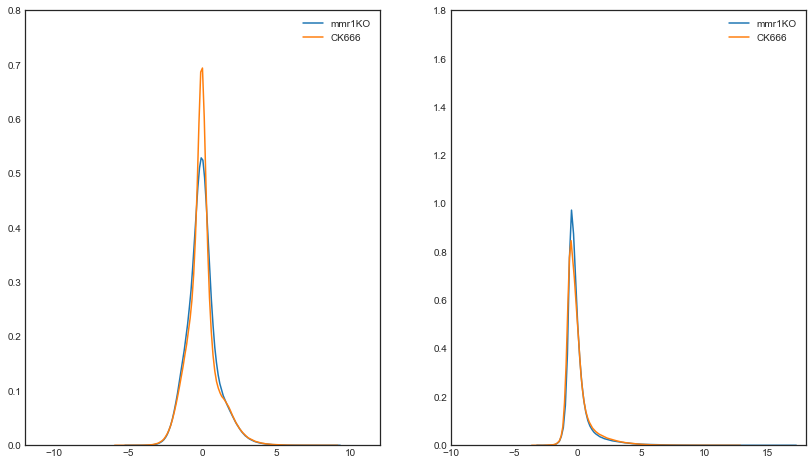

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))

for i in [2,3]:
    
    xs_clss = xs[ys == i] 
    xs_sub = xs_clss[:100,...]
    xs_sub = xs_sub.reshape(-1,2,50176)
    
    ch0, ch1 = np.ravel(xs_sub[:,0]), np.ravel(xs_sub[:,1])
    print(ch1.shape)

    sns.kdeplot(ch0, ax = axarr[0], label = data.classes[i])
    sns.kdeplot(ch1, ax = axarr[1], label = data.classes[i])
    
axarr[0].set_xlim(-12,12);
axarr[1].set_xlim(-10,18);   
axarr[0].set_ylim(0,0.8);
axarr[1].set_ylim(0,1.8);
axarr[1].legend()

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

# Training setup

In [16]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

Defining network architecture. 

In [21]:
# set architecture 
arch = resnet34_c

In [22]:
# build model
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

wd=1e-5 # weight-decay/L2 regularization 

In [23]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 6272)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [25]:
## Load model weights:

learn.load('YNet_v11.1_ResNet34_dihedral_ps025_IntNorm_rot90_rGauss_balanced_FT_87')
learn.freeze()

In [26]:
# initialize model
%time learn.fit(1e-10, 1, cycle_len=1, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                              
mean: [15.5641  13.07692 14.4359  12.71795 13.74359 14.02564 12.79487]
stdev: [4.98611 4.38754 6.80043 3.55866 4.03649 4.00312 3.8175 ]

[WT]: 89.05%
[mfb1KO]: 97.14%
[mmr1KO]: 87.14%
[CK666]: 38.57%
[LatA-5uM]: 81.43%
[dnm1KO]: 100.0%
[fzo1KO]: 100.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.265799   0.377405   0.857143  

Wall time: 22.3 s


[array([0.37741]), 0.8571428580889626]

## Confusion Matrix

In [27]:
log_preds, y = learn.TTA(n_aug=4) # run predictions with TTA

[[186   1   6  40   5   0   0]
 [  9  69   0   0   1   0   1]
 [  4   0  63   0   2   0   0]
 [  5   0   1  26   2   0   0]
 [  2   0   0   4  58   0   0]
 [  1   0   0   0   0  70   0]
 [  3   0   0   0   2   0  69]]


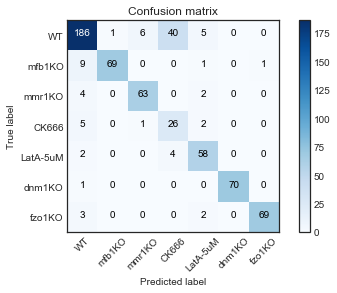

In [28]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

## Plot embeddings

In [29]:
# function to be called by register_forward_hook
# this function will collect outputs of a given layer
# it runs one full epoch for trn, val and test datasets 

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [30]:
embeddings = get_embeddings('14') # input the layer name (see with: learn.models.model)

In [31]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(2444, 512)
(630, 512)
(2721, 512)
(2444,)
(630,)
(2721,)


In [32]:
import umap

In [33]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

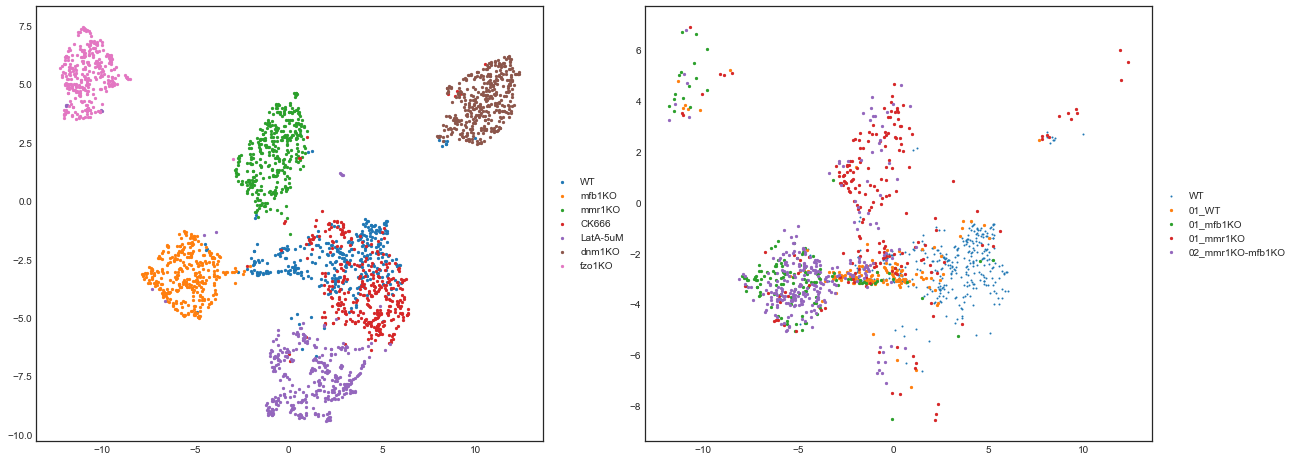

In [34]:
# plotting UMAP results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 1)

#     axarr[0].set_xlim(-22,15)
#     axarr[0].set_ylim(-15,12)
    
for i in [0,1,3,5]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], label = list(lbl2idx_test.keys())[i], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-22,15)
#     axarr[1].set_ylim(-15,12)


In [ ]:
print(lbl2idx_test)

## Evaluate predictions on test-dataset

In [35]:
test_log_preds, targs = learn.predict_with_targs('test')
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

In [36]:
test_log_preds.shape
preds.shape

(2721,)

In [37]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(lbl2idx_test.keys()):
    l = h
    h = h + list(data.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

01_WT predictions ready (140 elements)
01_mfb1KO predictions ready (140 elements)
01_mmm1KO predictions ready (195 elements)
01_mmr1KO predictions ready (205 elements)
01_num1KO predictions ready (75 elements)
02_mmr1KO-mfb1KO predictions ready (284 elements)
03_DTT predictions ready (258 elements)
03_Eth predictions ready (260 elements)
03_H2O2 predictions ready (310 elements)
03_LatA-05uM predictions ready (309 elements)
03_axl1KO predictions ready (290 elements)
03_bud1KO predictions ready (255 elements)


In [38]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data.classes)}
    preds_rel[key]= val

01_WT
01_mfb1KO
01_mmm1KO
01_mmr1KO
01_num1KO
02_mmr1KO-mfb1KO
03_DTT
03_Eth
03_H2O2
03_LatA-05uM
03_axl1KO
03_bud1KO


In [39]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

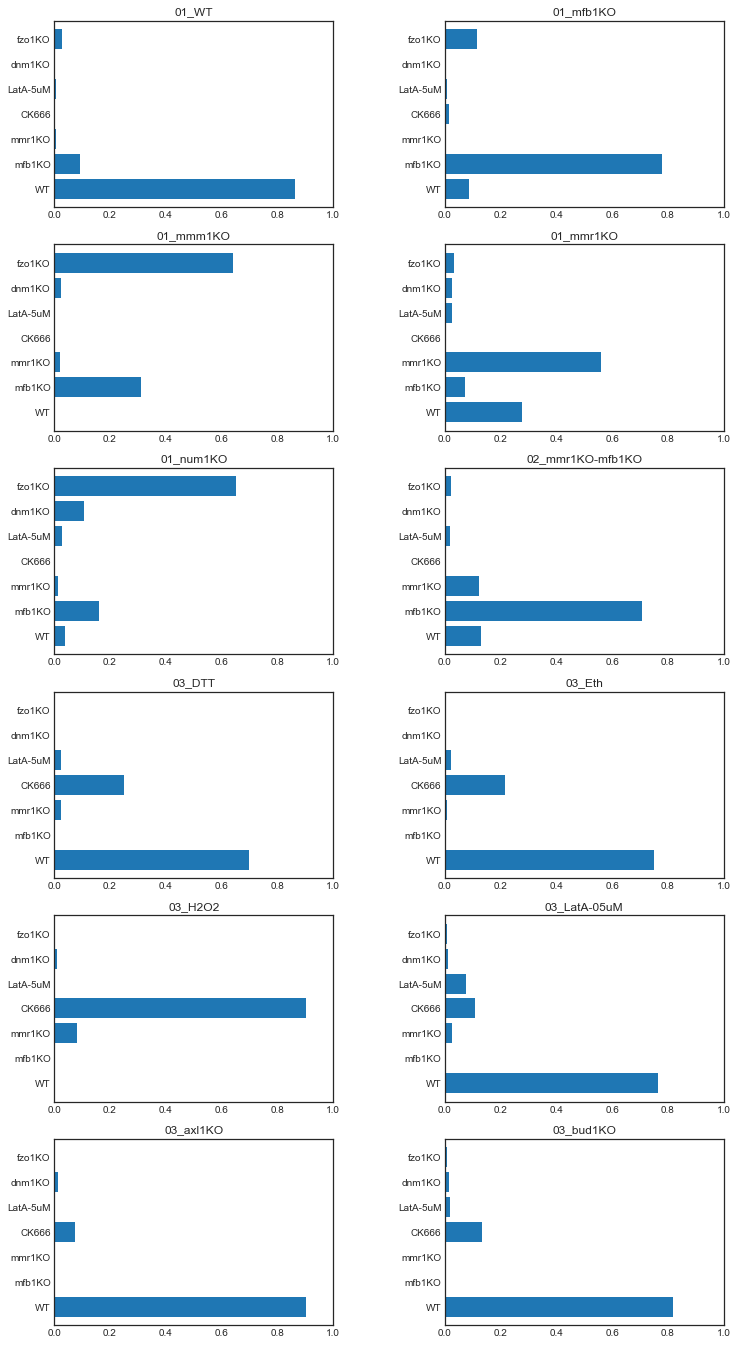

In [40]:
test_classes = list(lbl2idx_test.keys())
plot_test_preds(test_classes, preds_rel)